## ただの線形回帰モデル

In [35]:
# 変数リセット
%reset -s -f

In [36]:
import os
from functools import partial
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist

# for CI testing
smoke_test = ('CI' in os.environ)
# assert pyro.__version__.startswith('1.3.1')
pyro.enable_validation(True)
pyro.set_rng_seed(1)
pyro.enable_validation(True)


# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [37]:
# 地形の不整地とGDPの相関
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
# "rgdppc_2000"カラムでNaNとinfを取り除く
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])
df

,cont_africa,rugged,rgdppc_2000
2,1,0.858,7.492609
4,0,3.427,8.216929
7,0,0.769,9.933263
8,0,0.775,9.407032
9,0,2.688,7.792343
...,...,...,...
229,0,1.677,8.488849
230,0,2.323,6.669180
231,1,1.761,9.150497
232,1,0.533,6.651585


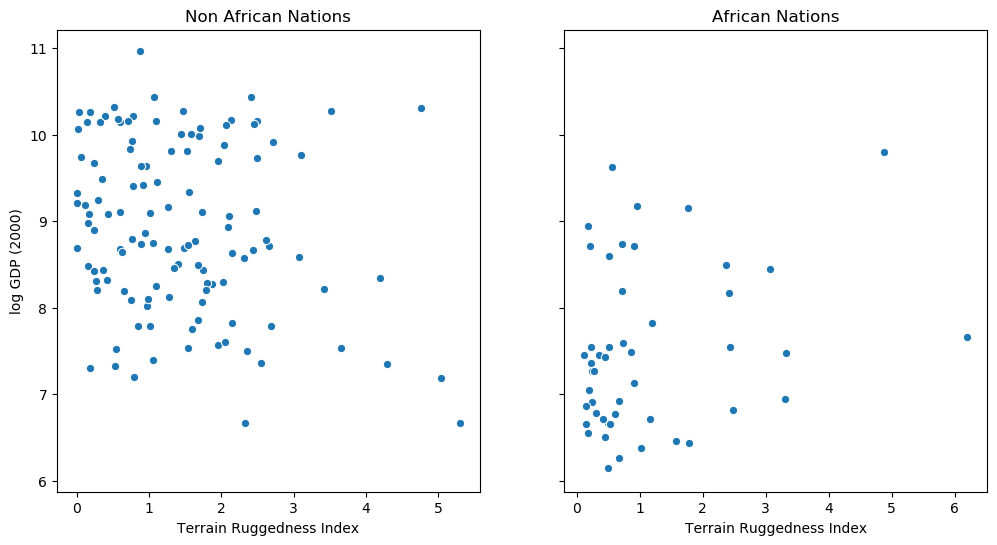

In [38]:
# sharey: 二つのグラフの高さを合わせる
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]
sns.scatterplot(non_african_nations["rugged"],
            non_african_nations["rgdppc_2000"],
            ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
sns.scatterplot(african_nations["rugged"],
                african_nations["rgdppc_2000"],
                ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

In [39]:
from torch import nn
from pyro.nn import PyroModule

assert issubclass(PyroModule[nn.Linear], nn.Linear)
assert issubclass(PyroModule[nn.Linear], PyroModule)

In [40]:
# "cont_africa"と"rugged"をかけた値を新しいカラム"cont_africa_x_rugged"にセット
df["cont_africa_x_rugged"] = df["cont_africa"] * df["rugged"]
df

,cont_africa,rugged,rgdppc_2000,cont_africa_x_rugged
2,1,0.858,7.492609,0.858
4,0,3.427,8.216929,0.000
7,0,0.769,9.933263,0.000
8,0,0.775,9.407032,0.000
9,0,2.688,7.792343,0.000
...,...,...,...,...
229,0,1.677,8.488849,0.000
230,0,2.323,6.669180,0.000
231,1,1.761,9.150497,1.761
232,1,0.533,6.651585,0.533


In [41]:
data = torch.tensor(df[["cont_africa", "rugged", "cont_africa_x_rugged", "rgdppc_2000"]].values,
                        dtype=torch.float)
data.shape

torch.Size([170, 4])

In [42]:
x_data, y_data = data[:, :-1], data[:, -1]
x_data.shape

torch.Size([170, 3])

In [43]:
# Regression model
linear_reg_model = PyroModule[nn.Linear](3, 1)# x_data:3， y_data:1からきてる？入力3、出力1

# Define loss and optimize
# reduction=sumでデータ数で割らないようにしてる。これだとMSELossではない気がする
loss_fn = torch.nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(linear_reg_model.parameters(), lr=0.05)
num_iterations = 1500 if not smoke_test else 2

def train():
    # run the model forward on the data
    y_pred = linear_reg_model(x_data).squeeze(-1)
    # calculate the mse loss
    loss = loss_fn(y_pred, y_data)
    # initialize gradients to zero
    optim.zero_grad()
    # backpropagate
    loss.backward()
    # take a gradient step
    optim.step()
    return loss

for j in range(num_iterations):
    loss = train()
    if (j + 1) % 50 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss.item()))


# Inspect learned parameters
print("Learned parameters:")
for name, param in linear_reg_model.named_parameters():
    print(name, param.data.numpy())

[iteration 0050] loss: 3179.7852
[iteration 0100] loss: 1616.1372
[iteration 0150] loss: 1109.4119
[iteration 0200] loss: 833.7545
[iteration 0250] loss: 637.5822
[iteration 0300] loss: 488.2652
[iteration 0350] loss: 376.4650
[iteration 0400] loss: 296.0484
[iteration 0450] loss: 240.6140
[iteration 0500] loss: 203.9386
[iteration 0550] loss: 180.6171
[iteration 0600] loss: 166.3494
[iteration 0650] loss: 157.9457
[iteration 0700] loss: 153.1786
[iteration 0750] loss: 150.5735
[iteration 0800] loss: 149.2020
[iteration 0850] loss: 148.5065
[iteration 0900] loss: 148.1668
[iteration 0950] loss: 148.0070
[iteration 1000] loss: 147.9347
[iteration 1050] loss: 147.9032
[iteration 1100] loss: 147.8900
[iteration 1150] loss: 147.8847
[iteration 1200] loss: 147.8827
[iteration 1250] loss: 147.8819
[iteration 1300] loss: 147.8817
[iteration 1350] loss: 147.8815
[iteration 1400] loss: 147.8815
[iteration 1450] loss: 147.8815
[iteration 1500] loss: 147.8815
Learned parameters:
weight [[-1.94785

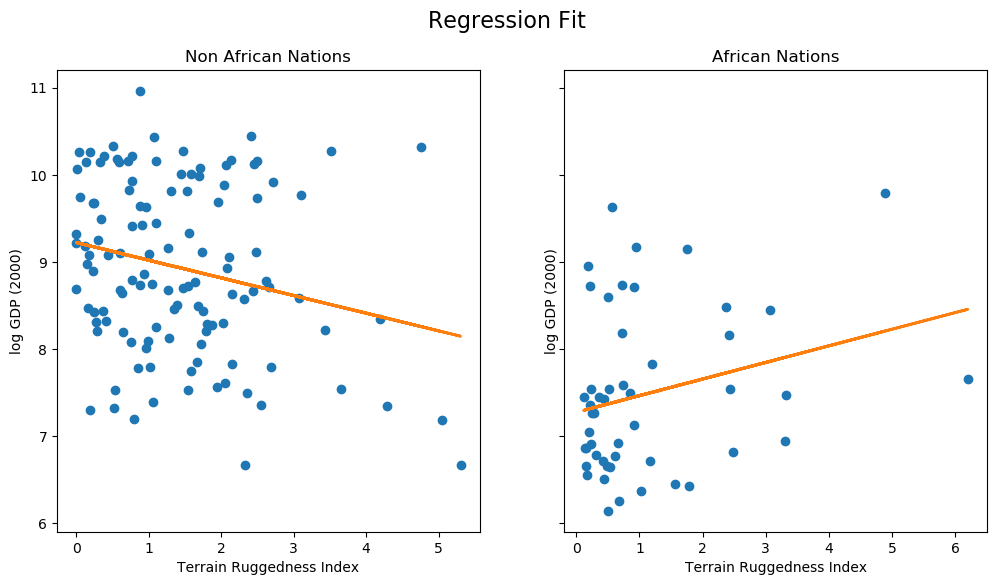

In [44]:
fit = df.copy()
# print(x_data[0])
# tensor([1.0000, 0.8580, 0.8580])
# print(linear_reg_model(x_data[0]))
# tensor([7.4387], grad_fn=<AddBackward0>)
# 学習済みモデルにデータを与えて、その出力値を"mean"カラムに追加。これをplotして繋げたものがモデル
fit["mean"] = linear_reg_model(x_data).detach().cpu().numpy()
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = fit[fit["cont_africa"] == 1]
non_african_nations = fit[fit["cont_africa"] == 0]
fig.suptitle("Regression Fit", fontsize=16)
# "rgdppc_2000"は上で対数をとって値を入れ直してることに注意。だから縦軸はlog GDP
ax[0].plot(non_african_nations["rugged"], non_african_nations["rgdppc_2000"], "o")
ax[0].plot(non_african_nations["rugged"], non_african_nations["mean"], linewidth=2)
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
ax[1].plot(african_nations["rugged"], african_nations["rgdppc_2000"], "o")
ax[1].plot(african_nations["rugged"], african_nations["mean"], linewidth=2)
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

## ここからベイズ線形回帰

In [45]:
from pyro.nn import PyroSample


class BayesianRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        # wに対して平均0、分散1の正規分布を事前分布として仮定
        # to_event()は独立性を担保するための関数らしい？
        self.linear.weight = PyroSample(dist.Normal(0., 1.).expand([out_features, in_features]).to_event(2))
        # wに対して平均0、分散10の正規分布を事前分布として仮定
        self.linear.bias = PyroSample(dist.Normal(0., 10.).expand([out_features]).to_event(1))

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

In [46]:
from pyro.infer.autoguide import AutoDiagonalNormal

model = BayesianRegression(3, 1)
guide = AutoDiagonalNormal(model)

In [47]:
from pyro.infer import SVI, Trace_ELBO

adam = pyro.optim.Adam({"lr": 0.03})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

In [48]:
pyro.clear_param_store()
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(x_data, y_data)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))

[iteration 0001] loss: 6.2310
[iteration 0101] loss: 3.5253
[iteration 0201] loss: 3.2347
[iteration 0301] loss: 3.0890
[iteration 0401] loss: 2.6377
[iteration 0501] loss: 2.0626
[iteration 0601] loss: 1.4852
[iteration 0701] loss: 1.4631
[iteration 0801] loss: 1.4632
[iteration 0901] loss: 1.4592
[iteration 1001] loss: 1.4940
[iteration 1101] loss: 1.4988
[iteration 1201] loss: 1.4938
[iteration 1301] loss: 1.4679
[iteration 1401] loss: 1.4581


In [49]:
# パラメータの確認
guide.requires_grad_(False)

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

AutoDiagonalNormal.loc Parameter containing:
tensor([-2.2371, -1.8097, -0.1691,  0.3791,  9.1823])
AutoDiagonalNormal.scale tensor([0.0551, 0.1142, 0.0387, 0.0769, 0.0702])


In [50]:
# 分位数の表示
guide.quantiles([0.25, 0.5, 0.75])

{'sigma': [tensor(0.9328), tensor(0.9647), tensor(0.9976)],
 'linear.weight': [tensor([[-1.8868, -0.1952,  0.3272]]),
  tensor([[-1.8097, -0.1691,  0.3791]]),
  tensor([[-1.7327, -0.1429,  0.4309]])],
 'linear.bias': [tensor([9.1350]), tensor([9.1823]), tensor([9.2297])]}

In [52]:
from pyro.infer import Predictive


def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            # 事後分布の両側95%確信区間?
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats


predictive = Predictive(model, guide=guide, num_samples=800,
                        return_sites=("linear.weight", "obs", "_RETURN"))
samples = predictive(x_data)
pred_summary = summary(samples)

In [55]:
samples

{'linear.weight': tensor([[[[-1.7410, -0.2398,  0.3089]]],
 
 
         [[[-2.0327, -0.1134,  0.3555]]],
 
 
         [[[-1.8550, -0.1015,  0.2323]]],
 
 
         ...,
 
 
         [[[-1.6234, -0.1968,  0.2318]]],
 
 
         [[[-1.6714, -0.1626,  0.4050]]],
 
 
         [[[-1.8433, -0.1800,  0.2747]]]]),
 'obs': tensor([[ 6.1138,  8.0007,  6.8885,  ...,  8.8967,  8.4047,  9.3302],
         [ 7.0296,  9.0401,  8.4839,  ...,  8.5399,  8.7620,  7.0875],
         [ 6.8786,  7.2515,  9.2445,  ...,  7.5788,  6.6871,  7.6604],
         ...,
         [ 8.0309, 10.4886, 10.7908,  ...,  7.2255,  6.7566,  7.1571],
         [ 7.7375, 11.3044,  9.3261,  ...,  9.2721,  8.5577,  7.6065],
         [ 6.7862,  8.4107,  9.2942,  ...,  7.5121,  9.2269,  6.9309]]),
 '_RETURN': tensor([[7.4890, 8.3488, 8.9862,  ..., 7.5514, 7.4665, 7.5122],
         [7.2876, 8.7241, 9.0254,  ..., 7.5062, 7.2089, 7.3689],
         [7.3020, 8.6970, 8.9668,  ..., 7.4202, 7.2595, 7.3460],
         ...,
         [7.6362, 8.55

In [56]:
pred_summary

{'linear.weight': {'mean': tensor([[[-1.8127, -0.1688,  0.3821]]]),
  'std': tensor([[[0.1197, 0.0378, 0.0787]]]),
  '5%': tensor([[[-2.0111, -0.2316,  0.2557]]]),
  '95%': tensor([[[-1.6147, -0.1053,  0.5148]]])},
 'obs': {'mean': tensor([7.5726, 8.6105, 9.0481, 9.0772, 8.7176, 9.2193, 9.1950, 8.5242, 8.9723,
          7.7782, 9.1089, 7.4243, 7.4189, 9.1720, 8.8852, 9.1683, 9.1284, 8.7935,
          9.1321, 9.0850, 9.0771, 9.1716, 9.0159, 7.4798, 7.5001, 9.0348, 8.4289,
          8.8026, 8.8927, 7.3877, 7.5080, 7.4020, 7.3934, 9.0093, 8.0748, 7.8821,
          8.8451, 8.7171, 9.0556, 9.0904, 7.9357, 9.2545, 9.1664, 8.8926, 7.4753,
          8.9764, 7.5097, 7.9126, 8.8590, 9.1030, 7.7476, 9.0442, 8.9459, 9.0231,
          7.4297, 9.0792, 8.6077, 7.4578, 7.5098, 7.4473, 7.4480, 7.4525, 8.6372,
          8.7793, 8.9021, 9.1686, 8.7502, 8.7346, 8.8751, 8.7590, 9.1065, 8.9670,
          9.0162, 9.0447, 8.8031, 8.9041, 8.9314, 8.7474, 8.9303, 9.0270, 8.8457,
          9.1218, 7.5293, 8.4492

In [57]:
mu = pred_summary["_RETURN"]
y = pred_summary["obs"]
predictions = pd.DataFrame({
    "cont_africa": x_data[:, 0],
    "rugged": x_data[:, 1],
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_gdp": y_data,
})
predictions

,cont_africa,rugged,mu_mean,mu_perc_5,mu_perc_95,y_mean,y_perc_5,y_perc_95,true_gdp
0,1.0,0.858,7.555369,7.292316,7.809373,7.572637,5.934160,9.119144,7.492610
1,0.0,3.427,8.606601,8.357883,8.845628,8.610497,6.976715,10.273925,8.216929
2,0.0,0.769,9.055232,8.931866,9.183099,9.048117,7.471318,10.609390,9.933263
3,0.0,0.775,9.054227,8.930706,9.182102,9.077241,7.483035,10.675345,9.407031
4,0.0,2.688,8.731320,8.519779,8.926593,8.717588,7.177963,10.278834,7.792343
...,...,...,...,...,...,...,...,...,...
165,0.0,1.677,8.901975,8.741949,9.054358,8.866485,7.292165,10.516268,8.488849
166,0.0,2.323,8.792947,8.599834,8.971646,8.772238,7.203745,10.398060,6.669179
167,1.0,1.761,7.747973,7.413618,8.068728,7.732246,6.221471,9.158417,9.150497
168,1.0,0.533,7.486056,7.243047,7.726580,7.488658,5.890152,9.044229,6.651585


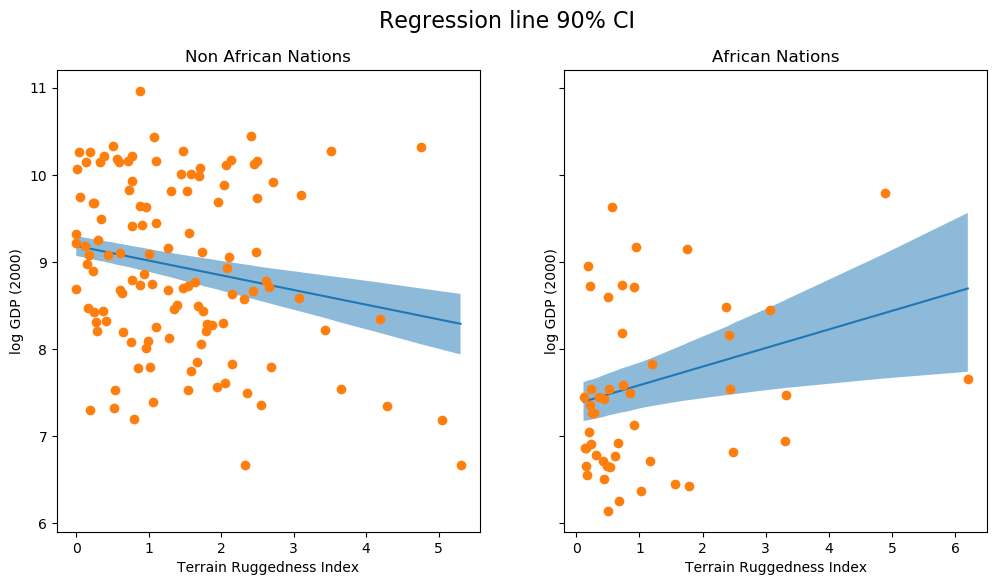

In [58]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = predictions[predictions["cont_africa"] == 1]
non_african_nations = predictions[predictions["cont_africa"] == 0]
african_nations = african_nations.sort_values(by=["rugged"])
non_african_nations = non_african_nations.sort_values(by=["rugged"])
fig.suptitle("Regression line 90% CI", fontsize=16)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["mu_mean"])
ax[0].fill_between(non_african_nations["rugged"],
                   non_african_nations["mu_perc_5"],
                   non_african_nations["mu_perc_95"],
                   alpha=0.5)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["true_gdp"],
           "o")
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
idx = np.argsort(african_nations["rugged"])
ax[1].plot(african_nations["rugged"],
           african_nations["mu_mean"])
ax[1].fill_between(african_nations["rugged"],
                   african_nations["mu_perc_5"],
                   african_nations["mu_perc_95"],
                   alpha=0.5)
ax[1].plot(african_nations["rugged"],
           african_nations["true_gdp"],
           "o")
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

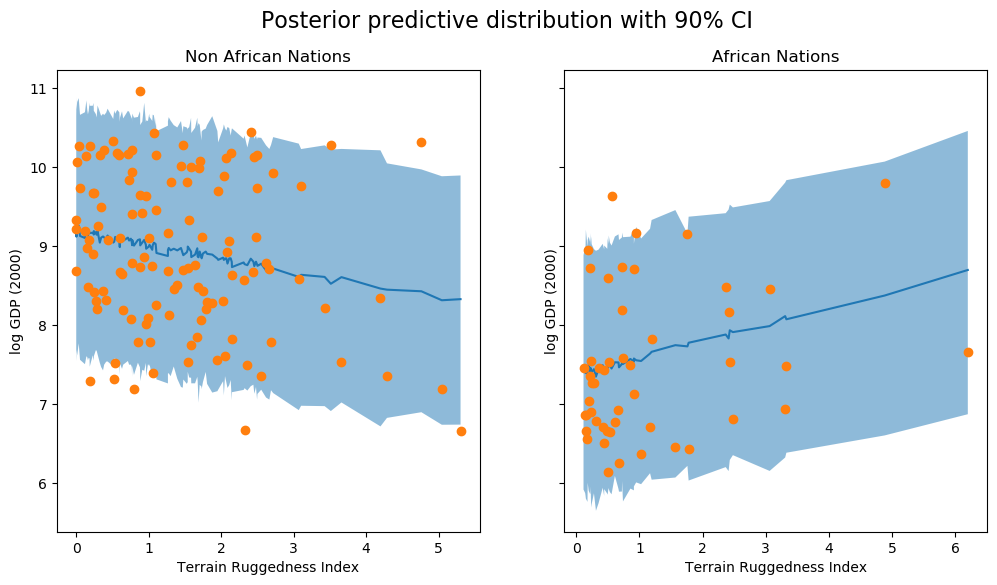

In [59]:
# 上のプログラムではmu_meanなどmuに関する値を用いてグラフを描画しているが， 
# それでは分散が考慮されないのでy_meanなどyの値を用いる
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle("Posterior predictive distribution with 90% CI", fontsize=16)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["y_mean"])
ax[0].fill_between(non_african_nations["rugged"],
                   non_african_nations["y_perc_5"],
                   non_african_nations["y_perc_95"],
                   alpha=0.5)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["true_gdp"],
           "o")
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
idx = np.argsort(african_nations["rugged"])

ax[1].plot(african_nations["rugged"],
           african_nations["y_mean"])
ax[1].fill_between(african_nations["rugged"],
                   african_nations["y_perc_5"],
                   african_nations["y_perc_95"],
                   alpha=0.5)
ax[1].plot(african_nations["rugged"],
           african_nations["true_gdp"],
           "o")
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

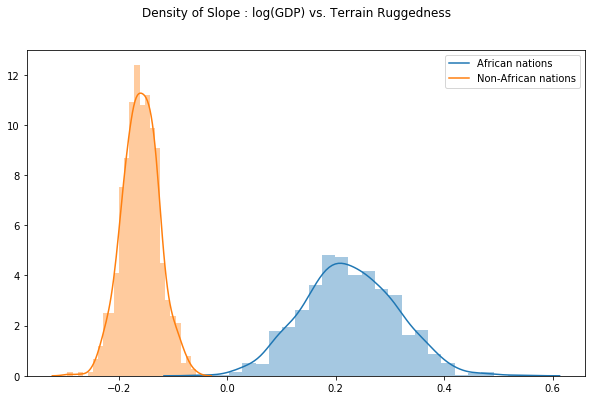

In [32]:
weight = samples["linear.weight"]
weight = weight.reshape(weight.shape[0], 3)
gamma_within_africa = weight[:, 1] + weight[:, 2]
gamma_outside_africa = weight[:, 1]
fig = plt.figure(figsize=(10, 6))
sns.distplot(gamma_within_africa, kde_kws={"label": "African nations"},)
sns.distplot(gamma_outside_africa, kde_kws={"label": "Non-African nations"})
fig.suptitle("Density of Slope : log(GDP) vs. Terrain Ruggedness");

In [33]:
from collections import defaultdict
from pyro import poutine
from pyro.poutine.util import prune_subsample_sites
import warnings


class Predict(torch.nn.Module):
    def __init__(self, model, guide):
        super().__init__()
        self.model = model
        self.guide = guide

    def forward(self, *args, **kwargs):
        samples = {}
        guide_trace = poutine.trace(self.guide).get_trace(*args, **kwargs)
        model_trace = poutine.trace(poutine.replay(self.model, guide_trace)).get_trace(*args, **kwargs)
        for site in prune_subsample_sites(model_trace).stochastic_nodes:
            samples[site] = model_trace.nodes[site]['value']
        return tuple(v for _, v in sorted(samples.items()))

predict_fn = Predict(model, guide)
predict_module = torch.jit.trace_module(predict_fn, {"forward": (x_data,)}, check_trace=False)

In [ ]:
torch.jit.save(predict_module, '/tmp/reg_predict.pt')
pred_loaded = torch.jit.load('/tmp/reg_predict.pt')
pred_loaded(x_data)

In [ ]:
weight = []
for _ in range(800):
    # index = 1 corresponds to "linear.weight"
    weight.append(pred_loaded(x_data)[1])
weight = torch.stack(weight).detach()
weight = weight.reshape(weight.shape[0], 3)
gamma_within_africa = weight[:, 1] + weight[:, 2]
gamma_outside_africa = weight[:, 1]
fig = plt.figure(figsize=(10, 6))
sns.distplot(gamma_within_africa, kde_kws={"label": "African nations"},)
sns.distplot(gamma_outside_africa, kde_kws={"label": "Non-African nations"})
fig.suptitle("Loaded TorchScript Module : log(GDP) vs. Terrain Ruggedness");